# Spatial Autocorrelation #


In this notebook we introduce methods of _exploratory spatial data analysis_
that are intended to complement geovizualization through formal univariate and
multivariate statistical tests for spatial clustering.

In [ ]:
import pandas as pd
import geopandas as gpd
import libpysal as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline

In [ ]:
#we will get Columbus neighborhood crime data

In [6]:
df = gpd.read_file('D:/geospatial analysis in python/data/columbus/columbus.geojson')

In [7]:
df.head()

,AREA,PERIMETER,COLUMBUS_,COLUMBUS_I,POLYID,NEIG,HOVAL,INC,CRIME,OPEN,...,DISCBD,X,Y,NSA,NSB,EW,CP,THOUS,NEIGNO,geometry
0,0.309441,2.440629,2,5,1,5,80.467003,19.531,15.725980,2.850747,...,5.03,38.799999,44.070000,1,1,1,0,1000,1005,"POLYGON ((8.62413 14.23698, 8.55970 14.74245, ..."
1,0.259329,2.236939,3,1,2,1,44.567001,21.232,18.801754,5.296720,...,4.27,35.619999,42.380001,1,1,0,0,1000,1001,"POLYGON ((8.25279 14.23694, 8.28276 14.22994, ..."
2,0.192468,2.187547,4,6,3,6,26.350000,15.956,30.626781,4.534649,...,3.89,39.820000,41.180000,1,1,1,0,1000,1006,"POLYGON ((8.65331 14.00809, 8.81814 14.00205, ..."
3,0.083841,1.427635,5,2,4,2,33.200001,4.477,32.387760,0.394427,...,3.70,36.500000,40.520000,1,1,0,0,1000,1002,"POLYGON ((8.45950 13.82035, 8.47341 13.83227, ..."
4,0.488888,2.997133,6,7,5,7,23.225000,11.252,50.731510,0.405664,...,2.83,40.009998,38.000000,1,1,1,0,1000,1007,"POLYGON ((8.68527 13.63952, 8.67758 13.72221, ..."


#we will plot the crimes in neighbourhood to see the general pattern

<AxesSubplot:>

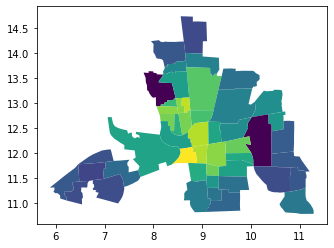

In [8]:
df.plot(column='CRIME')

<AxesSubplot:>

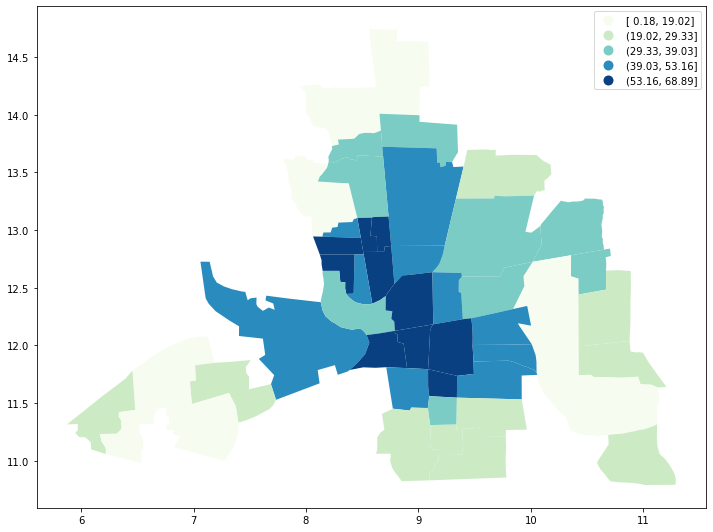

In [11]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
df.plot(column='CRIME', scheme='Quantiles', 
        k=5, cmap='GnBu', legend=True, ax=ax)

### Spatial Similarity ###
the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

In [17]:
wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'

### Attribute Similarity ###

So the spatial weight between districts $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighbourhood
$i$ the spatial lag is defined as: $$y_i = \sum_j w_{i,j} y_j$$

In [19]:
y = df['CRIME']
ylag = lp.weights.lag_spatial(wq, y)

In [20]:
ylag

array([24.7142675 , 26.24684033, 29.411751  , 34.64647575, 40.4653275 ,
       40.6237135 , 49.728447  , 41.49913083, 36.9477815 , 25.328384  ,
       49.857447  , 43.25009117, 38.093982  , 42.82053817, 50.10508383,
       52.36547225, 18.09104533, 51.18116975, 46.442163  , 32.4463615 ,
       43.72131433, 35.90408433, 18.74605433, 54.90555729, 49.97125037,
       48.62930967, 33.20419825, 47.42423011, 51.79066157, 48.5733284 ,
       19.12681567, 13.8546865 , 37.27826625, 22.1371835 , 33.098551  ,
       18.7549056 , 50.99421883, 43.65270583, 16.171101  , 21.0544898 ,
       21.06991733, 19.139792  , 36.16118067, 35.747272  , 32.07386125,
       16.7032095 , 17.5732225 , 28.5489635 , 27.21200567])

In [22]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

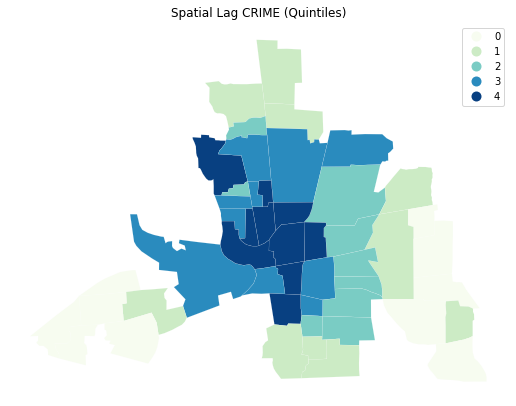

In [23]:
f,ax = plt.subplots(1, figsize=(9, 9), subplot_kw=dict(aspect='equal'))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True,
        k=5, cmap='GnBu', linewidth=0.1,
        edgecolor='white', legend=True, ax=ax)
ax.set_axis_off()
plt.title("Spatial Lag CRIME (Quintiles)")

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

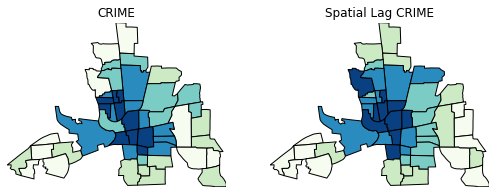

In [24]:
df['lag_CRIME'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4), subplot_kw=dict(aspect='equal'))
df.plot(column='CRIME', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("CRIME")
df.plot(column='lag_CRIME', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag CRIME")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

## Global Spatial Autocorrelation ##

### Continuous Case ###

First, we transform our weights to be row-standardized, from the current binary state:

In [27]:
wq.transform = 'r'

In [28]:
y = df['CRIME']

We can use the `esda` package from PySAL to carry out join count analysis:

In [32]:
import esda 


Moran's I is a test for global autocorrelation for a continuous attribute:

In [33]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.5001885571828611

our value for the statistic needs to be interpreted against a reference
distribution under the null of CSR. PySAL : random spatial permutations.

Text(0.5, 0, "Moran's I")

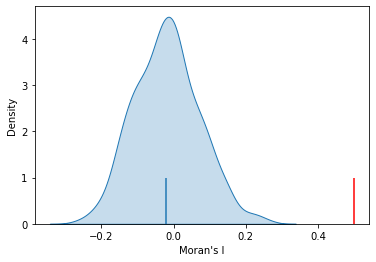

In [34]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")


In [35]:
mi.p_sim

0.001

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers ##

In addition to the Global autocorrelation statistics, PySAL has many local
autocorrelation statistics. Let's compute a local Moran statistic for the same
d

In [36]:
np.random.seed(12345)

In [38]:
wq.transform = 'r'
lag_crime = lp.weights.lag_spatial(wq, df['CRIME'])

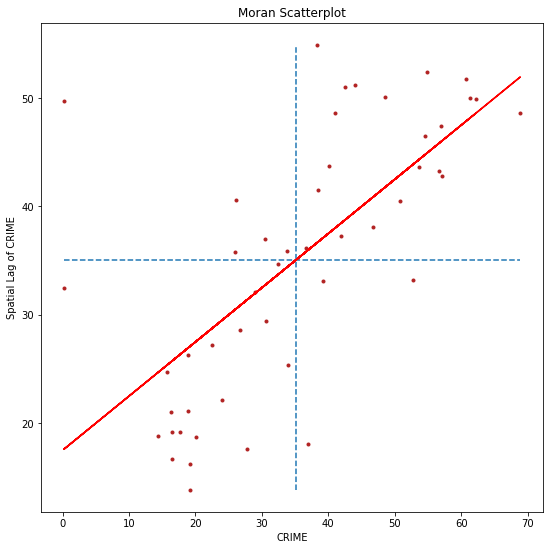

In [39]:
crime = df['CRIME']
b, a = np.polyfit(crime, lag_crime, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(crime, lag_crime, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(crime.mean(), lag_crime.min(), lag_crime.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_crime.mean(), crime.min(), crime.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(crime, a + b*crime, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of CRIME')
plt.xlabel('CRIME')
plt.show()

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

In [40]:
li = esda.moran.Moran_Local(y, wq)

In [41]:
li.q

array([3, 3, 3, 3, 1, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 2,
       3, 1, 1, 1, 4, 1, 1, 1, 3, 3, 1, 3, 4, 3, 1, 1, 3, 3, 3, 3, 1, 2,
       3, 3, 3, 3, 3])

We can again test for local clustering using permutations, but here we use
conditional random permutations (different distributions for each focal location)

In [42]:
(li.p_sim < 0.05).sum()

21

We can distinguish the specific type of local spatial association reflected in
the four quadrants of the Moran Scatterplot above:

In [44]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [45]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

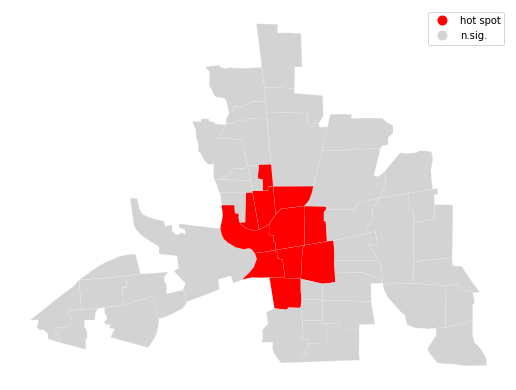

In [46]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [47]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

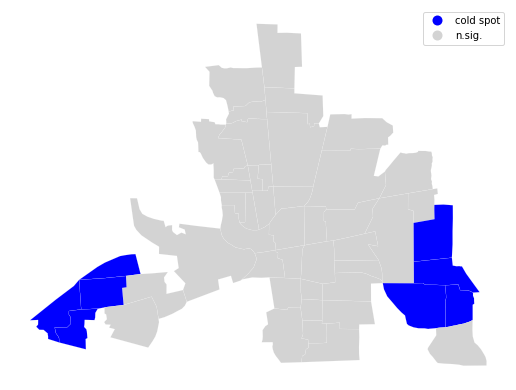

In [48]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [49]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

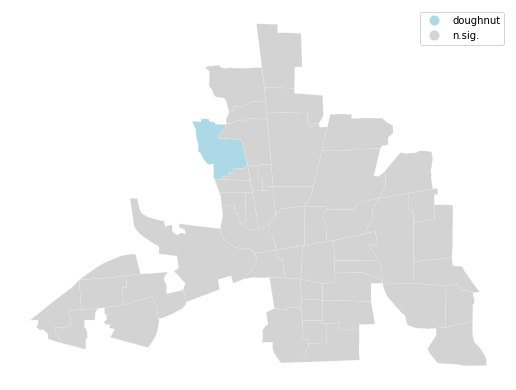

In [50]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [51]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

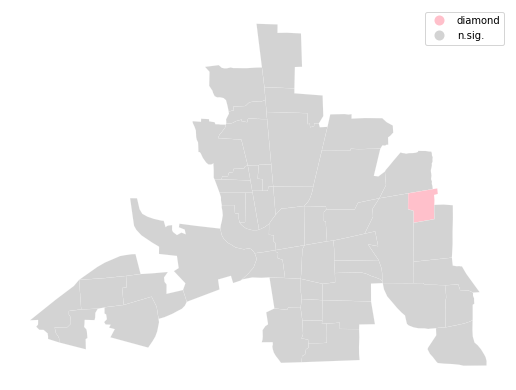

In [52]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [53]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 4, 1, 0, 0, 0, 0,
       3, 1, 1, 1, 0, 1, 1, 1, 3, 3, 0, 0, 0, 3, 1, 0, 3, 3, 3, 0, 0, 0,
       0, 3, 0, 0, 0])

In [54]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

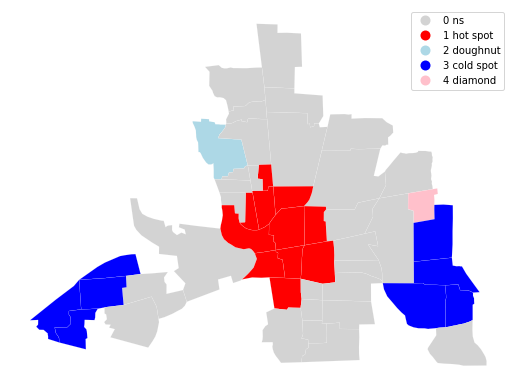

In [55]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()